
✅ Regression - Temperature:
RMSE: 0.91 °C

✅ Regression - Precipitation Probability:
RMSE: 0.015

✅ Classification - Weather Condition (Balanced):
Accuracy: 87.88%
              precision    recall  f1-score   support

       clear       0.94      0.91      0.93       639
       rainy       0.58      0.69      0.63       112

    accuracy                           0.88       751
   macro avg       0.76      0.80      0.78       751
weighted avg       0.89      0.88      0.88       751



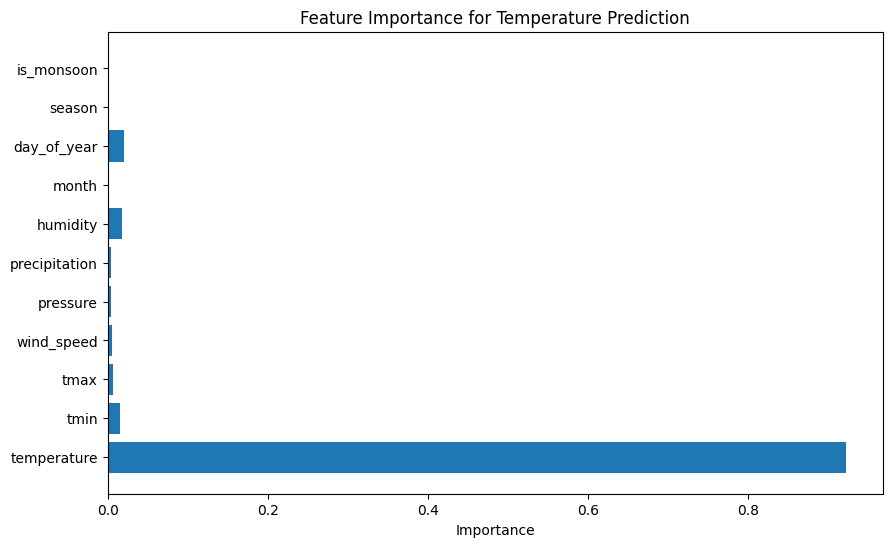

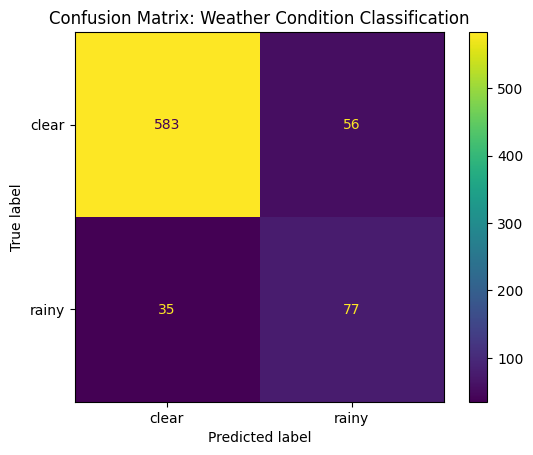

In [12]:
# 1. Install Dependencies (Run once)
!pip install meteostat scikit-learn imbalanced-learn pandas numpy matplotlib

# 2. Imports
from meteostat import Point, Daily, Hourly
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
import warnings

warnings.filterwarnings("ignore", message="Support for nested sequences for 'parse_dates'")
warnings.filterwarnings("ignore", message="'H' is deprecated")

# 3. Fetch Weather Data (Pune)
location = Point(18.5204, 73.8567)  # Pune
start = datetime(2015, 1, 1)
end = datetime(2025, 4, 10)

# Daily Data
daily_data = Daily(location, start, end).fetch().reset_index()
daily_data.rename(columns={
    'time': 'date_time',
    'tavg': 'temperature',
    'prcp': 'precipitation',
    'wspd': 'wind_speed',
    'pres': 'pressure'
}, inplace=True)

daily_data = daily_data[['date_time', 'temperature', 'tmin', 'tmax', 'precipitation', 'wind_speed', 'pressure']]
daily_data.fillna(daily_data.median(numeric_only=True), inplace=True)

# Hourly Humidity (compute daily average)
hourly_data = Hourly(location, start, end).fetch().reset_index()
hourly_data['date_time'] = hourly_data['time'].dt.date
humidity = hourly_data.groupby('date_time')['rhum'].mean().reset_index()
humidity.rename(columns={'rhum': 'humidity'}, inplace=True)
humidity['date_time'] = pd.to_datetime(humidity['date_time'])

# Merge humidity with daily data
df = pd.merge(daily_data, humidity, on='date_time', how='left')

# Add Targets
df['forecasted_temperature'] = df['temperature'].shift(-1)
max_precip = df['precipitation'].max()
df['precipitation_probability'] = df['precipitation'] / (max_precip + 0.001)
df['forecasted_precip_prob'] = df['precipitation_probability'].shift(-1)
df['weather_condition'] = np.where(df['precipitation'] > 1.0, 'rainy', 'clear')
df['forecasted_condition'] = df['weather_condition'].shift(-1)

# Add Time Features
df['month'] = df['date_time'].dt.month
df['day_of_year'] = df['date_time'].dt.dayofyear
df['season'] = df['month'] % 12 // 3 + 1
df['is_monsoon'] = df['month'].isin([6, 7, 8, 9]).astype(int)

# Drop NaNs after shifting
df.dropna(inplace=True)

# 4. Model Training & Evaluation
features = ['temperature', 'tmin', 'tmax', 'wind_speed', 'pressure',
            'precipitation', 'humidity', 'month', 'day_of_year', 'season', 'is_monsoon']

target_reg_temp = 'forecasted_temperature'
target_reg_precip = 'forecasted_precip_prob'
target_cls = 'forecasted_condition'

X = df[features]

# Regression - Temperature
y_temp = df[target_reg_temp]
X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X, y_temp, test_size=0.2, random_state=42)

# Regression - Precipitation Probability
y_precip = df[target_reg_precip]
X_train_precip, X_test_precip, y_train_precip, y_test_precip = train_test_split(X, y_precip, test_size=0.2, random_state=42)

# Classification - Weather Condition
y_cond = df[target_cls]
X_train_cond, X_test_cond, y_train_cond, y_test_cond = train_test_split(X, y_cond, test_size=0.2, random_state=42)

# Train Models
reg_temp = RandomForestRegressor(n_estimators=100, random_state=42)
reg_temp.fit(X_train_temp, y_train_temp)

reg_precip = RandomForestRegressor(n_estimators=100, random_state=42)
reg_precip.fit(X_train_precip, y_train_precip)

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train_cond, y_train_cond)

cls_cond = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
cls_cond.fit(X_resampled, y_resampled)

# Evaluation
y_pred_temp = reg_temp.predict(X_test_temp)
rmse_temp = np.sqrt(mean_squared_error(y_test_temp, y_pred_temp))

y_pred_precip = reg_precip.predict(X_test_precip)
rmse_precip = np.sqrt(mean_squared_error(y_test_precip, y_pred_precip))

y_pred_cond = cls_cond.predict(X_test_cond)
acc_cond = accuracy_score(y_test_cond, y_pred_cond)

# Results
print(f"\n✅ Regression - Temperature:\nRMSE: {rmse_temp:.2f} °C")
print(f"\n✅ Regression - Precipitation Probability:\nRMSE: {rmse_precip:.3f}")
print(f"\n✅ Classification - Weather Condition (Balanced):\nAccuracy: {acc_cond:.2%}")
print(classification_report(y_test_cond, y_pred_cond))

# Optional: Plot Feature Importances for Temperature
importances = reg_temp.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.title("Feature Importance for Temperature Prediction")
plt.xlabel("Importance")
plt.show()

# Optional: Confusion Matrix for Classification
cm = confusion_matrix(y_test_cond, y_pred_cond, labels=cls_cond.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls_cond.classes_)
disp.plot()
plt.title("Confusion Matrix: Weather Condition Classification")
plt.show()


In [17]:
df["predicted"]=y_pred

NameError: name 'y_pred' is not defined

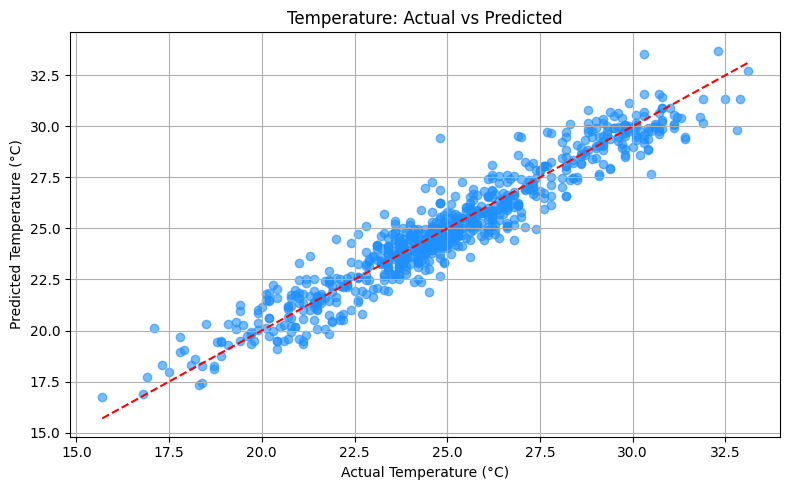

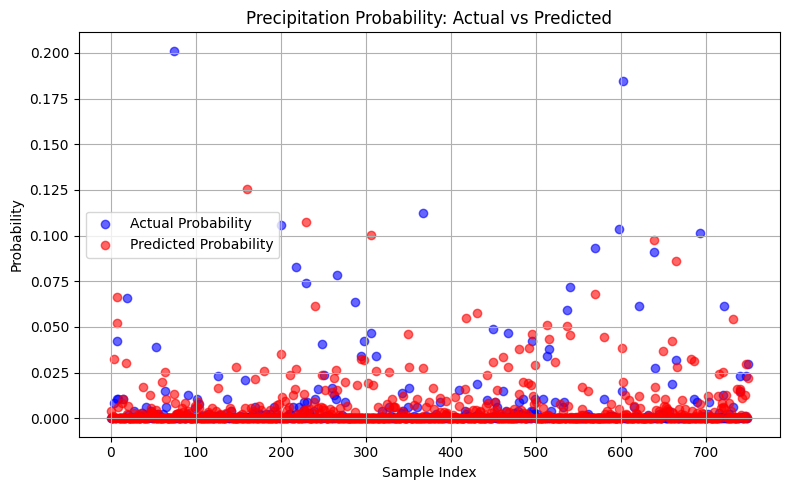

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# -----------------------------
# 1. Predicted vs Actual: Temperature
# -----------------------------
plt.figure(figsize=(8, 5))
plt.scatter(y_test_temp, y_pred_temp, alpha=0.6, color='dodgerblue')
plt.plot([y_test_temp.min(), y_test_temp.max()], [y_test_temp.min(), y_test_temp.max()], 'r--')
plt.title("Temperature: Actual vs Predicted")
plt.xlabel("Actual Temperature (°C)")
plt.ylabel("Predicted Temperature (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# 2. Predicted vs Actual: Precipitation Probability
# -----------------------------
plt.figure(figsize=(8, 5))

# Plot actual values (pink)
plt.scatter(range(len(y_test_precip)), y_test_precip, alpha=0.6, color='blue', label='Actual Probability')

# Plot predicted values (red)
plt.scatter(range(len(y_pred_precip)), y_pred_precip, alpha=0.6, color='red', label='Predicted Probability')

plt.title("Precipitation Probability: Actual vs Predicted")
plt.xlabel("Sample Index")
plt.ylabel("Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


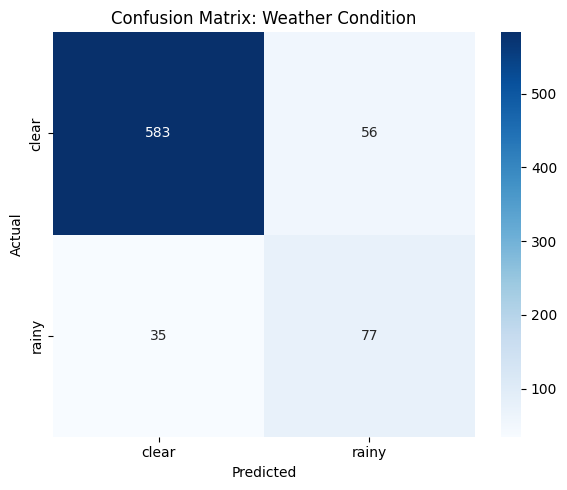

In [14]:
# -----------------------------
# 3. Confusion Matrix: Weather Condition
# -----------------------------
cm = confusion_matrix(y_test_cond, y_pred_cond, labels=cls_cond.classes_)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=cls_cond.classes_,
            yticklabels=cls_cond.classes_)
plt.title("Confusion Matrix: Weather Condition")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [16]:
df.tail()

,date_time,temperature,tmin,tmax,precipitation,wind_speed,pressure,humidity,forecasted_temperature,precipitation_probability,forecasted_precip_prob,weather_condition,forecasted_condition,month,day_of_year,season,is_monsoon
3747,2025-04-05,28.5,19.8,37.2,0.0,6.5,1010.6,37.958333,29.3,0.0,0.0,clear,clear,4,95,2,0
3748,2025-04-06,29.3,18.8,39.2,0.0,7.6,1009.4,32.291667,30.3,0.0,0.0,clear,clear,4,96,2,0
3749,2025-04-07,30.3,21.8,38.5,0.0,9.9,1009.8,25.125000,31.4,0.0,0.0,clear,clear,4,97,2,0
3750,2025-04-08,31.4,23.4,39.4,0.0,10.1,1010.1,25.958333,30.6,0.0,0.0,clear,clear,4,98,2,0
3751,2025-04-09,30.6,21.8,39.6,0.0,12.8,1009.4,41.416667,29.3,0.0,0.0,clear,clear,4,99,2,0
